In [2]:
from os import listdir, path
from pyteomics import fasta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [3]:
fastafile = '/projects/mipt_dbmp_biotechnology/proteomics/sp_human_canonical_2023-09-06_shuffled.fasta'

# Конвертация сырых спектров в mzML

In [44]:
%%time
filedir = '/projects/mipt_dbmp_biotechnology/proteomics/hw/'
outdir = '/home/vpiskaeva/homework/homework_3_2term/mzML/'
for file in listdir(filedir):
    if file.endswith('.raw') and file.replace('raw', 'mzML') not in listdir(outdir):
        path_to_file = path.join(filedir, file)
        !/projects/mipt_dbmp_biotechnology/soft/ThermoRawFileParser/ThermoRawFileParser -i $path_to_file -o $outdir

=2025-11-18 19:56:27 INFO Started parsing /projects/mipt_dbmp_biotechnology/proteomics/hw/LUM2_00800_VG_6138B_3.raw
2025-11-18 19:56:38 INFO Processing 84484 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2025-11-18 19:59:17 INFO Finished parsing /projects/mipt_dbmp_biotechnology/proteomics/hw/LUM2_00800_VG_6138B_3.raw
2025-11-18 19:59:17 INFO Processing completed 0 errors, 0 warnings
=2025-11-18 19:59:17 INFO Started parsing /projects/mipt_dbmp_biotechnology/proteomics/hw/LUM2_00806_VG_6138A_1.raw
2025-11-18 19:59:28 INFO Processing 87115 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2025-11-18 20:01:58 INFO Finished parsing /projects/mipt_dbmp_biotechnology/proteomics/hw/LUM2_00806_VG_6138A_1.raw
2025-11-18 20:01:58 INFO Processing completed 0 errors, 0 warnings
=2025-11-18 20:01:58 INFO Started parsing /projects/mipt_dbmp_biotechnology/proteomics/hw/LUM2_00817_VG_4114B_1.raw
2025-11-18 20:02:07 INFO Processing 84579 MS scans
10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

2

# Идентификация белков

Запускаем MSFragger через slurm

# Пост-поисковая валидация

In [46]:
%%time
filedir = '/home/vpiskaeva/homework/homework_3_2term/mzML'
outdir = '/home/vpiskaeva/homework/homework_3_2term/fragger_scavager'
for file in listdir(filedir):
    filename = file.split('.')[0] 
    if file.endswith('.pepXML') and filename + '_protein_groups.tsv' not in listdir(outdir):
        print(file)
        path_to_pepxml = path.join(filedir, file)
        !/home/vpiskaeva/.conda/envs/proteomics/bin/scavager -p DECOY_ -db $fastafile -o $outdir $path_to_pepxml

LUM2_00840_VG_4114K_6.pepXML
     INFO: [22:03:50] 1 file(s) to process.
     INFO: [22:03:50] Loading file LUM2_00840_VG_4114K_6.pepXML...
     INFO: [22:04:02] Default target-decoy filtering, 1% PSM FDR: Number of target PSMs = 29466
     INFO: [22:04:02] Calibrating retention model...
     INFO: [22:04:23] RT model training results: R^2 = 0.853956 , std = 10.784510
     INFO: [22:04:23] Retention model calibrated successfully.
     INFO: [22:04:23] Starting machine learning...
     INFO: [22:05:54] Machine learning is finished.
     INFO: [22:06:00] Final results at 1.0% FDR level:
     INFO: [22:06:00] Identified PSMs: 30725
     INFO: [22:06:00] Identified peptides: 22308
     INFO: [22:06:00] Identified proteins: 3986
     INFO: [22:06:00] Identified protein groups: 3486
     INFO: [22:06:00] Processing finished.
     INFO: [22:06:05] Output tables saved.
     INFO: [22:06:15] Figures saved.
LUM2_00818_VG_4114B_2.pepXML
     INFO: [22:06:41] 1 file(s) to process.
     INFO: [22:0

# Количественный анализ + анализ дифференциальной экспресии

## Считаем число белков в фасте

In [47]:
i = 0
for p in fasta.read(fastafile):
    i+=1
print("Число настоящих белков в базе данных:",  i//2)

Число настоящих белков в базе данных: 20423


## Создаем sample-file

In [48]:
import os

sample_df = pd.DataFrame(columns = ['File Name', 'SampleID'])
filedir = '/home/vpiskaeva/homework/homework_3_2term/fragger_scavager'
for file in listdir(filedir):
    if file.endswith('protein_groups.tsv'):
        name = file.split('_protein_groups')[0]
        sample = file.split('VG_')[1].split('_')[0]
        tmp_dict = {'File Name': [file],
                    'SampleID':[sample]}
        sample_df = pd.concat([sample_df, pd.DataFrame.from_dict(tmp_dict)])
outfile = os.path.join('/home/vpiskaeva/homework/homework_3_2term', 'sample_file_hw.csv')
sample_df.to_csv(outfile, index=False)

In [50]:
filedir = '/home/vpiskaeva/homework/homework_3_2term/fragger_scavager'
sample_file = '~/homework/homework_3_2term/sample_file_hw.csv'
outdir = '/home/vpiskaeva/homework/homework_3_2term/qreps_hw'

labels = '6138A,6138K 6138B,6138K 4114A,4114K 4114B,4114K'

!/home/vpiskaeva/.conda/envs/proteomics/bin/qreps \
    --sample-file $sample_file --labels $labels \
    --input-dir $filedir --output-dir $outdir \
    --imputation kNN --thresholds semi-dynamic --alpha 0.01 --regulation UP \
    --fasta-size 20423 --species 9606 --report True \
    --enrichment True

True
True
True
True


## Go enrichment analysis

Сайт string-db.org, списки генов в файлах DRG. 

## Post enrichment

## Визуализация топ10 терминов для каждой категории

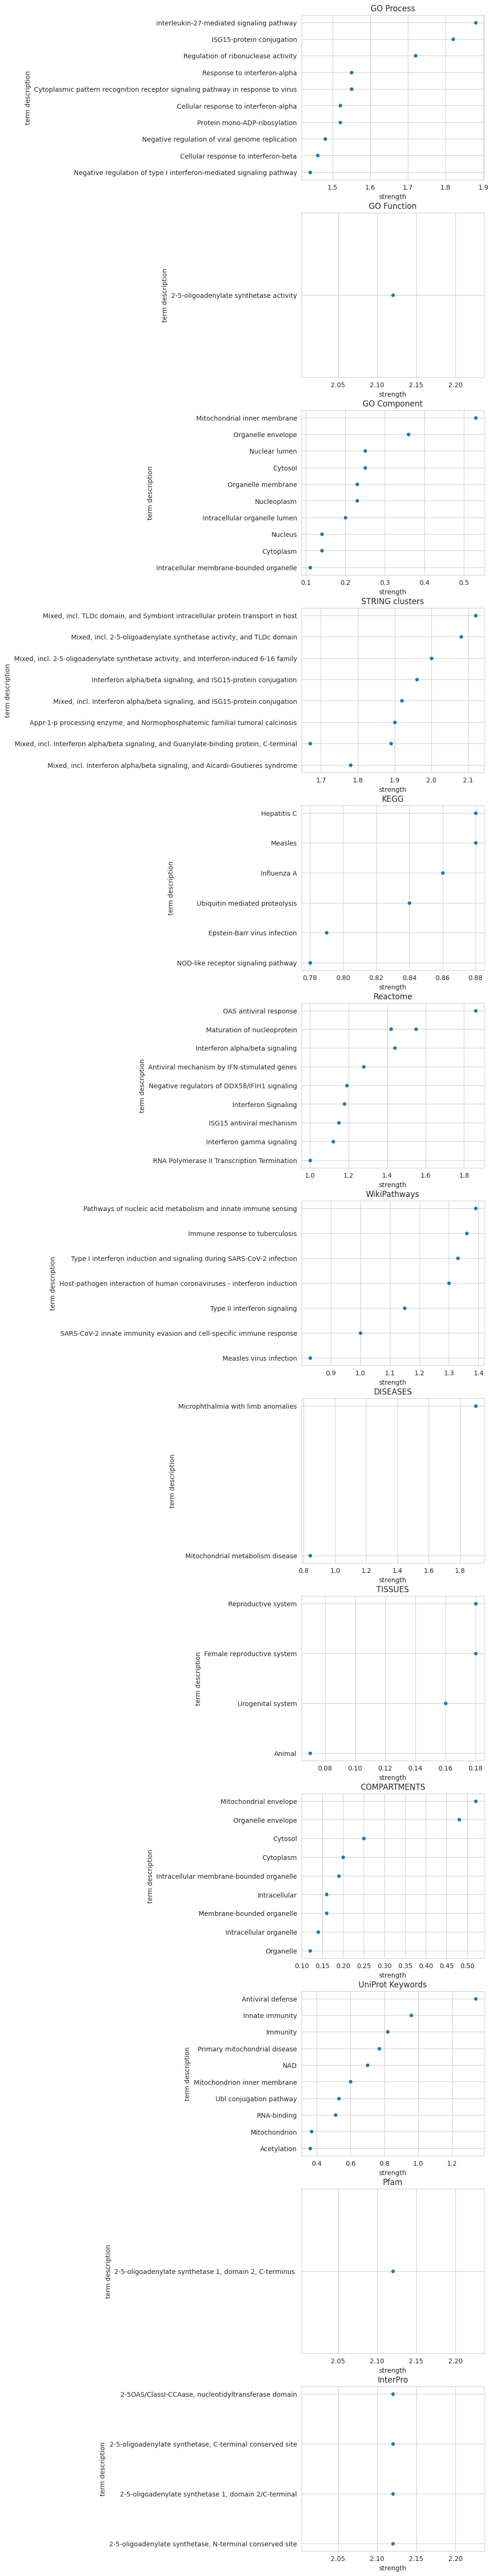

In [18]:
filedir = '/home/vpiskaeva/homework/homework_3_2term/qreps_hw'
for file in listdir(filedir):
    if file.startswith('enrichment'):
        df = pd.read_csv(path.join(filedir, file), sep = '\t')
        cats = df['#category'].unique()
        f, ax = plt.subplots(len(cats), 1, figsize = (5, 70))
        i = 0
        for c in cats:
            tmp = df[df['#category'] == c]
            tmp = tmp.sort_values(by = 'strength', ascending = False)
            sns.scatterplot(x = 'strength', y = 'term description', data = tmp.head(10), ax = ax[i])
            ax[i].set_title(c)
            i+=1
        plt.show()